# 1. Introduction

In this notebook we are going to deal with a unsupervised learning (learning without teacher) problem called K-Means clustering.

## 1.1 Clustering

The target of clustering is to find a function which can divide the dataset into the groups known as clusters. This function divide the dataset in a way that similar data instances are assigned to the same cluster, as a result dissimilar objects are assigned to different clusters. In this notebook we are going to work on customer churn data of a Telecom Company using **K-Means**.

### 1.1.1 K-Means Clustering
It is a method of clustering which assigns cluster by calculating the centroid of data points. K-Means work as follows:
    1. Initially two centroids are assigned one that has low values and the other that is nearest to this data point using Euclidean distance or any other distance metric.
    2. The distance between the clusters are then calculated iteratively, if a new point is added then value of centroid is updated by taking mean of the values.

# 2. Steps Involved:
    0. Importing the required libraries - for importing all the dependencies
    1. Making functions of the required steps
    2. Importing dataset
    3. Exploratory Data Analysis (EDA) and Preprocessing - for checking the nature and structure of dataset
    4. Feature Engineering - for getting features from the dataset
    5. Finding the best cluster value
    6. Model Building
    7. Model Training
    8. Saving the model
    9. Predicting labels
    10.Model Evaluation - for checking the utility of model

# 3. Prerequisites 

## 3.1 Dataset 
Telco-Customer-Churn.csv has been used as dataset which is consist of 21 columns:
    1. customerID      
    2. gender          
    3. SeniorCitizen   
    4. Partner         
    5. Dependents      
    6. tenure          
    7. PhoneService    
    8. MultipleLines   
    9. InternetService 
    10.OnlineSecurity  
    11.OnlineBackup    
    12.DeviceProtection
    13.TechSupport     
    14.StreamingTV     
    15.StreamingMovies 
    16.Contract     
    17.PaperlessBilling
    18.PaymentMethod   
    19.MonthlyCharges  
    20.TotalCharges    
    21.Churn
    
## 3.2 Libraries Required
    pandas == 0.24.2
    numpy == 1.16.3
    matplotlib == 3.0.3
    scikit_learn == 0.21.2
    
# 4. Use Case
Some famous use cases of K-Means clustering are :
    1. Segmenting customers on the basis of their buying behavior
    2. Anomaly detection, finding the most requests from an IP in a timestamp

## Step 0. Importing the required libraries

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

# Saving model
import pickle

# Preprocessing and Training
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Step 1. Making functions of the required steps

In [2]:
# FUNCTION FOR IMPORTING THE DATASET
# Input: path of the dataset (CSV)
# Output: dataframe 

def import_dataset(path):
    df = pd.read_csv(path)
    return df

In [3]:
# FUNCTION FOR HANDLING DATA TYPE
# Input: dataframe and column name
# Output: dataframe

def correct_dtype(df, col_name):
    df.loc[df[col_name] == ' ', col_name] = '0'
    df[col_name] = df[col_name].astype('float')
    
    return df

In [4]:
# FUNCTION FOR PLOTTING GENDER DISTRIBUTION WITH THEIR CHURN RATE
# Input: dataframe
# Output: pie chart showing distribution

def plt_gender_churn_distribution(df):
    gender_count = df.gender.value_counts()
    
    churn_by_gender = df.groupby(['Churn', 'gender'])['gender'].count()[::-1]
    churn_rate = [churn_by_gender[0], churn_by_gender[2], 
                  churn_by_gender[1], churn_by_gender[3]]
    # Colors
    male, female = [plt.cm.Blues, plt.cm.Reds]
    fig, ax = plt.subplots()
    ax.axis('equal')
    mypie, _ = ax.pie(gender_count.values, radius=1.3, labels=gender_count.index, 
                      colors=[male(0.6), female(0.75)])
    plt.setp(mypie, width=0.3, alpha=0.6)
    
    mypie2, _ = ax.pie(churn_rate, radius=1.3-0.3,  labeldistance=0.7,
                       colors=[male(0.5), male(0.4), female(0.5), female(0.4)], shadow=True)
    plt.setp(mypie2, width=0.4)
    
    # Male distribution
    plt.annotate('{:.2f}%'.format(gender_count.values[0] / gender_count.values.sum() * 100), 
                 xy=(.2, 1.1))
    
    # Male churn rate
    plt.annotate('Churn \n{:.2f}%'.format(churn_rate[0] / gender_count.values[0] * 100),
                 xy=(.55, 0.4))
    
    # Female distribution
    plt.annotate('{:.2f}%'.format(gender_count.values[1] / gender_count.values.sum() * 100),
                 xy=(0, -1.2))
    # Female churn rate
    plt.annotate('Churn \n{:.2f}%'.format(churn_rate[2] / gender_count.values[1] * 100),
                 xy=(-0.8, -0.5))
    plt.legend(loc='upper right')
    plt.show()

In [5]:
# FUNCTION FOR PLOTTING SHARE OF USERS THAT HAVE PHONE SERVICE
# Input: dataframe
# Output: horizontal bar plot

def plt_users_phone_service(df):
    user_phone_service = df.PhoneService.value_counts(normalize=True)
    
    users = pd.DataFrame({'x': [user_phone_service.values[0]], 'y': [user_phone_service.values[1]]})
    
    users.plot(kind='barh', stacked=True, legend=False,
               color=['#005f11', '#ef1100'], alpha=0.75)
    plt.axis('off')
    plt.annotate('Phone Users', xy=(0.35, 0.3), fontsize=14)
    plt.annotate("Don't Use", xy=(0.89, 0.3), fontsize=13.5)
    plt.annotate("{:.2f}%".format(users['x'][0]*100), xy=(0.37, 0),
                 color='#ffffff', fontsize=18)
    plt.annotate("{:.2f}%".format(users['y'][0]*100), xy=(0.91, 0),
                 color='#ffffff', fontsize=15)
    plt.show()

In [6]:
# FUNCTION FOR PLOTTING INTERNET SERVICE DISTRIBUTION WITH THEIR CHURN RATE
# Input: dataframe
# Output: Multiple bar plot on same axis

def plt_internet_churn(df):
    internet_service = df["InternetService"].value_counts()
    churn_internet_service = df.loc[df.Churn == 'Yes',
                                    'InternetService'].value_counts()
    distribution = []
    for val in internet_service.values:
        distribution.append((val / np.sum(internet_service.values))*100)
    
    churn_rate = (churn_internet_service.values / internet_service.values) * 100
    
    plt.bar(np.array([1, 2, 3]), distribution, width=0.20,
            color=['#F39C12', '#E67E22', '#D35400'], label="Service Distribution")
    
    plt.bar(np.array([1, 2, 3]) + 0.2, churn_rate, width=0.20, 
            label="Churn rate", alpha=0.8)
    
    plt.xlabel('Service Type')
    plt.ylabel('Value in %')
    plt.xticks(np.array([1, 2, 3])+0.1, internet_service.index)
    
    # Service Distribution
    plt.annotate("{:.2f}%".format(distribution[0]), (0.92, 41))
    plt.annotate("{:.2f}%".format(distribution[1]), (1.92, 31))
    plt.annotate("{:.2f}%".format(distribution[2]), (2.92, 19))
    
    # Churn rate
    plt.annotate("{:.2f}%".format(churn_rate[0]), (1.12, 38))
    plt.annotate("{:.2f}%".format(churn_rate[1]), (2.12, 16))
    plt.annotate("{:.2f}%".format(churn_rate[2]), (3.12, 5))
    
    plt.legend()
    plt.show()

In [7]:
# FUNCTION FOR PLOTTING CHURN RATE OF PHONE USERS WHO OPTED INTERNET SERVICE
# Input: dataframe
# Output: Multiple bar plot on same axis

def plt_phone_internet_churn(df):
    internet_service = df.InternetService.value_counts()
    have_internet = df.loc[df.PhoneService == 'Yes', 'InternetService'].value_counts()
    
    churn_internet_service = df.loc[(df.PhoneService == 'Yes') & (df.Churn == 'Yes'), 
                                    'InternetService'].value_counts()
    
    distribution = []
    for val in have_internet.values:
        distribution.append((val / have_internet.values.sum())*100)
        
    churn_rate = (churn_internet_service.values / have_internet.values) * 100
    
    plt.bar(np.array([1, 2, 3]), distribution, width=0.20,
            color=['#F39C12', '#E67E22', '#D35400'], label="Service Distribution")
    plt.bar(np.array([1, 2, 3]) + 0.2, churn_rate, width=0.20, 
            label="Churn rate", alpha=0.8)
    
    plt.xlabel('Service Type')
    plt.ylabel('Value in %')
    plt.xticks(np.array([1, 2, 3])+0.1, internet_service.index)
    
    # Service Distribution
    plt.annotate("{:.2f}%".format(distribution[0]), (0.92, 45))
    plt.annotate("{:.2f}%".format(distribution[1]), (1.92, 25))
    plt.annotate("{:.2f}%".format(distribution[2]), (2.92, 20))
    
    # Churn rate
    plt.annotate("{:.2f}%".format(churn_rate[0]), (1.12, 38))
    plt.annotate("{:.2f}%".format(churn_rate[1]), (2.12, 14))
    plt.annotate("{:.2f}%".format(churn_rate[2]), (3.12, 5))
    
    plt.legend()
    plt.show()

In [8]:
# FUNCTION TO PLOT THE RANGE OF MONTHLY CHARGES
# Input: dataframe
# Output: histogram

def plt_monthly_charges(df):
    plt.hist(df.MonthlyCharges, color='#112f8f')
    plt.xlabel('Monthly Charges range')
    plt.ylabel('Frequency')
    plt.show()

In [9]:
# FUNCTION TO PLOT THE CHURN RATE IN THESE RANGES
# Input: dataframe
# Output: line plot

def plt_monthly_charges_churn(df):
    x_ticks = []
    values = []
    
    for charge in range(0, 120, 20):
        churn = df.loc[(df.MonthlyCharges >= charge) & (df.MonthlyCharges < charge + 20),
                       'Churn'].value_counts()
        x_ticks.append(str(charge + 20))
        values.append(churn[1] / churn.values.sum() * 100)
        
    plt.plot(x_ticks, values, color='#d3660c', marker='X',
             alpha=0.8, linewidth=2)
    plt.xlabel('Monthly Charges range')
    plt.ylabel('Churn rate in %')
    plt.show()

In [10]:
# FUNCTION TO SHOW VARIANCE OF NUMERIC COLUMNS
# Input: dataframe
# Output: variance of columns not having dtype object

def variance(df):
    print(df.var())

In [11]:
# FUNCTION FOR SAVING THE MODEL
# Input: model object, file name
# Output: pickle file of the model

def save_pickle(model_object, pkl_name):
    file_pkl = open(pkl_name, 'wb')
    pickle.dump(model_object, file_pkl)
    file_pkl.close()

In [12]:
# FUNCTION FOR FEATURE SCALING
# Input: features
# Output: scaled features

def feature_scaling(X):
    sc = StandardScaler()
    X = sc.fit_transform(X)
    
    # Saving the learned scaler model
    save_pickle(sc, 'scaling_model/standard_scale.pkl')
    
    return X

In [13]:
# FUNCTION FOR FINDING THE BEST CLUSTER VALUE
# Input: scaled features
# Output: plot between Inertia and number of clusters

def find_best_cluster(X):
    wcss = []
    
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    
    plt.plot(range(1, 11), wcss, marker='o', linewidth=2.5)
    plt.xlabel('No. of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()

In [14]:
# FUNCTION FOR BUILDING THE MODEL
# Input: number of clusters
# Output: model object

def build_model(num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    
    return kmeans

In [15]:
# FUNCTION FOR TRAINING THE MODEL
# Input: model object and features
# Output: trained model

def train_model(kmeans, X):
    kmeans.fit(X)

In [16]:
# FUNCTION FOR PREDICTING LABELS
# Input: model_object and features
# Output: labels

def predict_label(kmeans, X):
    label = kmeans.predict(X)
    return label

In [17]:
# FUNCTION FOR ANALYZING THE CLUSTERS
# Input: model object, features and labels
# Output: plot that shows clusters with their centroids

def plt_clusters(kmeans, X, label):
    plt.scatter(X[label == 0, 0], X[label == 0, 1], s = 100,
                c = 'red', label = 'Cluster 1')
    plt.scatter(X[label == 1, 0], X[label == 1, 1], s = 100,
                c = 'blue', label = 'Cluster 2')
    plt.scatter(X[label == 2, 0], X[label == 2, 1], s = 100,
                c = 'green', label = 'Cluster 3')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, 
                c = 'yellow', label = 'Centroids')
    
    plt.xlabel('Monthly Charges')
    plt.ylabel('Tenure')
    plt.title('Churned customer clusters')
    plt.legend()
    plt.show()

## Step 2. Importing dataset

In [18]:
# Importing CSV
path = 'data/Telco-Customer-Churn.csv'
telco_user_churn = import_dataset(path)

## Step 3. Exploratory Data Analysis (EDA) and Preprocessing

In [19]:
# Checking the dataset
telco_user_churn.head() 

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [20]:
# Checking the shape of the data
# First entry represent the number of rows and second represents the number of columns
telco_user_churn.shape

(7043, 21)

In [21]:
# Checking the structure of data
telco_user_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [22]:
# Correcting dtype of TotalCharges column
telco_user_churn = correct_dtype(telco_user_churn, 'TotalCharges')

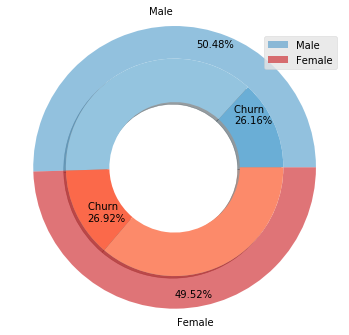

In [23]:
# Plotting Churn distribution by gender

# Plot style
plt.style.use('ggplot')
# Plot size
plt.rcParams['figure.figsize'] = [6, 5]

plt_gender_churn_distribution(telco_user_churn)

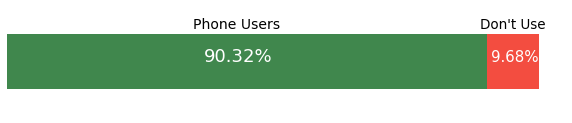

In [24]:
# Plotting share of phone users

# Plot size
plt.rcParams['figure.figsize'] = [10, 2]

plt_users_phone_service(telco_user_churn)

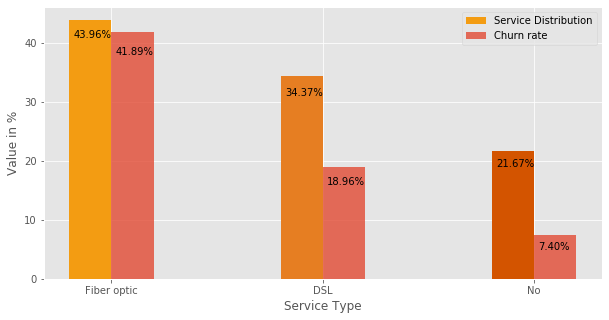

In [25]:
# Plotting Internet Service Distribution with churn rate

# Plot size
plt.rcParams['figure.figsize'] = [10, 5]

plt_internet_churn(telco_user_churn)

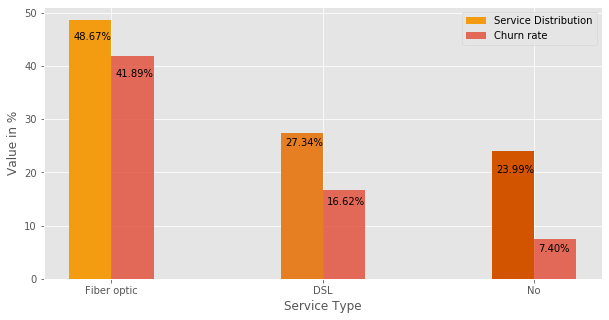

In [26]:
# Plotting phone Users that have internet service with their churn rate

# Plot size
plt.rcParams['figure.figsize'] = [10, 5]

plt_phone_internet_churn(telco_user_churn)

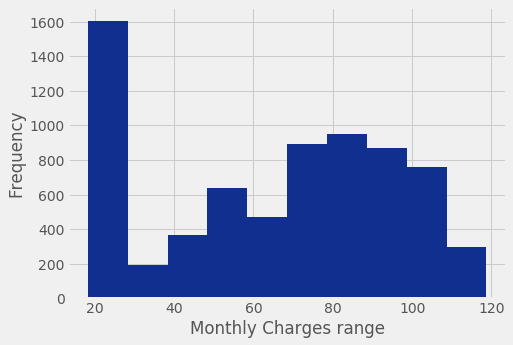

In [27]:
# Plotting the distribution of monthly charges

# Plot style
plt.style.use('fivethirtyeight')
# Plot size
plt.rcParams['figure.figsize'] = [7, 5]

plt_monthly_charges(telco_user_churn)

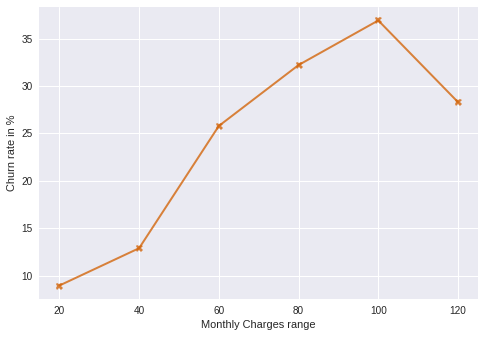

In [28]:
# Plotting the churn value in monthly charges

# Plot style
plt.style.use('seaborn')
# Plot size
plt.rcParams['figure.figsize'] = [7, 5]

plt_monthly_charges_churn(telco_user_churn)

## Step 4. Feature Engineering

In [29]:
# Analyzing the variance of features
variance(telco_user_churn)

SeniorCitizen     1.358745e-01
tenure            6.031681e+02
MonthlyCharges    9.054109e+02
TotalCharges      5.138357e+06
dtype: float64


In [30]:
# Getting features
X = telco_user_churn.loc[telco_user_churn.Churn == 'Yes',
                         ['MonthlyCharges', 'tenure']].values

In [31]:
# Scaling features
X = feature_scaling(X)

## Step 5. Finding best cluster value

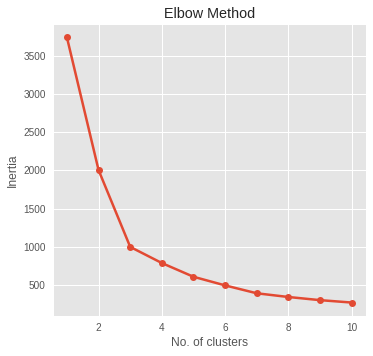

In [32]:
# Analyzing the best cluster value

# Plot style
plt.style.use('ggplot')
# Plot size
plt.rcParams['figure.figsize'] = [5, 5]

find_best_cluster(X)

## Step 6. Model Building

In [33]:
# Building the model
kmeans = build_model(num_clusters=3)

## Step 7. Model Training

In [34]:
# Training the model
train_model(kmeans, X)

## Step 8. Saving the model

In [35]:
# Saving model as pickle
save_pickle(kmeans, 'models/kmeans_churn.pkl')

## Step 9. Predicting labels

In [36]:
# Predicting labels from the learned pattern
labels = predict_label(kmeans, X)

## Step 10. Model Evaluation

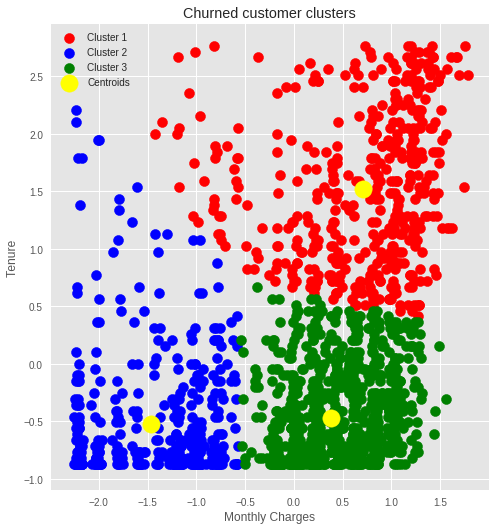

In [37]:
# Analyzing the formed clusters

# Plot size
plt.rcParams['figure.figsize'] = [7, 8]

plt_clusters(kmeans, X, labels)